In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from skimage.color import rgb2lab, lab2rgb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

In [4]:
transform_all = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
])


In [ ]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform):
        self.transform = transform
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy().convert('RGB'))
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = self.transform(img)

        img_lab = rgb2lab(img).astype(np.float32)
        img_lab = transforms.ToTensor()(img_lab)
        
        L, ab = img_lab[[0], :, :] ,img_lab[[1, 2], :, :]

        L_norm, ab_norm = torch.max(L), torch.max(ab)

        L = L / L_norm - 1.
        ab = ab / ab_norm

        return L, ab, L_norm, ab_norm

dataset = ColorizationDataset('universum-photos', transform_all)
loader = DataLoade(dataset, batch_size=64, shuffle=True)

In [11]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1),                                 
            nn.MaxPool2d((2, 2), stride=(2, 2)), 
            nn.ReLU(),
            
            nn.Conv2d(32, 64, (3, 3), padding=1),             
            nn.ReLU(),

            nn.Conv2d(64, 128, (3, 3), padding=1),             
            nn.MaxPool2d((2, 2), stride=(2, 2)), # [1 x 32 x 32]
            nn.ReLU(),

            nn.Conv2d(128, 256, (3, 3), padding=1),             
            nn.ReLU(),

            nn.Conv2d(256, 256, (3, 3), padding=1),             
            nn.ReLU(),

            nn.Upsample(scale_factor=2),         
            nn.Conv2d(256, 128, (3, 3), padding=1),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2),         
            nn.Conv2d(128, 64, (3, 3), padding=1),
            nn.ReLU(),

        )
         
        self.postconcat = nn.Sequential(        
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 2, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)

        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 1001
lr = 1e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()  

Epoch :0 0.1564490646123886


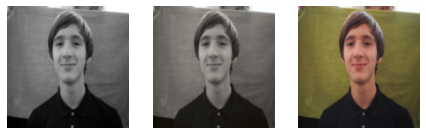

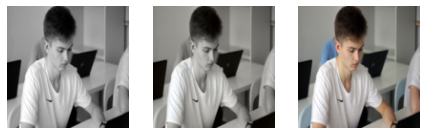

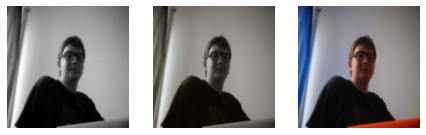

Epoch :1 0.14046725630760193
Epoch :2 0.15704257786273956
Epoch :3 0.15021482110023499
Epoch :4 0.1641727089881897
Epoch :5 0.15443284809589386
Epoch :6 0.15550291538238525
Epoch :7 0.15318025648593903
Epoch :8 0.1550436019897461
Epoch :9 0.16187413036823273
Epoch :10 0.1499122679233551
Epoch :11 0.15829229354858398
Epoch :12 0.13971102237701416
Epoch :13 0.16438809037208557
Epoch :14 0.14043350517749786
Epoch :15 0.15479902923107147
Epoch :16 0.1533564031124115
Epoch :17 0.15560850501060486
Epoch :18 0.15602484345436096
Epoch :19 0.1296740621328354
Epoch :20 0.13229259848594666
Epoch :21 0.13926094770431519
Epoch :22 0.14295528829097748
Epoch :23 0.14773441851139069
Epoch :24 0.14915277063846588
Epoch :25 0.14868248999118805
Epoch :26 0.1454060673713684
Epoch :27 0.14790619909763336
Epoch :28 0.15257993340492249
Epoch :29 0.14661015570163727
Epoch :30 0.14973175525665283
Epoch :31 0.13748659193515778
Epoch :32 0.13734214007854462
Epoch :33 0.14426831901073456
Epoch :34 0.1419878453016

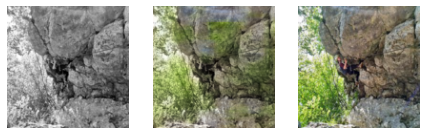

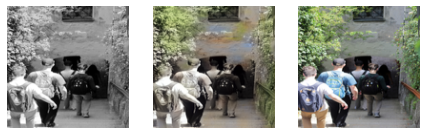

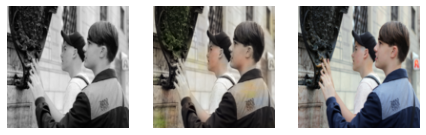

Epoch :101 0.12188597768545151
Epoch :102 0.12981180846691132
Epoch :103 0.11551487445831299
Epoch :104 0.11733835190534592
Epoch :105 0.11729713529348373
Epoch :106 0.1228165403008461
Epoch :107 0.12909679114818573
Epoch :108 0.13605919480323792
Epoch :109 0.11442170292139053
Epoch :110 0.1259918510913849
Epoch :111 0.11613035202026367
Epoch :112 0.11926134675741196
Epoch :113 0.11310514062643051
Epoch :114 0.1198987290263176
Epoch :115 0.1279563158750534
Epoch :116 0.12344107031822205
Epoch :117 0.13778653740882874
Epoch :118 0.13102969527244568
Epoch :119 0.12010958045721054
Epoch :120 0.1134168952703476
Epoch :121 0.12185768038034439
Epoch :122 0.12383663654327393
Epoch :123 0.1113562285900116
Epoch :124 0.11623687297105789
Epoch :125 0.10585542023181915
Epoch :126 0.10383480787277222
Epoch :127 0.13184940814971924
Epoch :128 0.12343351542949677
Epoch :129 0.12978495657444
Epoch :130 0.1095346063375473
Epoch :131 0.1100066751241684
Epoch :132 0.11302566528320312
Epoch :133 0.115123

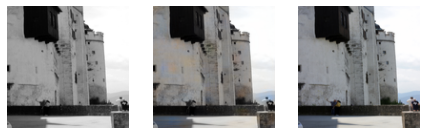

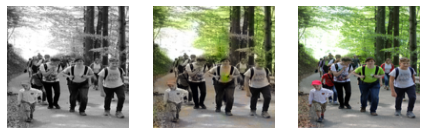

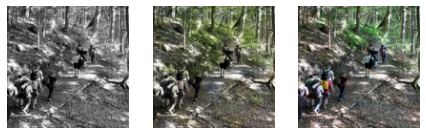

Epoch :201 0.09894073009490967
Epoch :202 0.09266459196805954
Epoch :203 0.09595850110054016
Epoch :204 0.09932857751846313
Epoch :205 0.09799020737409592
Epoch :206 0.09150310605764389
Epoch :207 0.11374488472938538
Epoch :208 0.09517496079206467
Epoch :209 0.10713906586170197
Epoch :210 0.0938144102692604
Epoch :211 0.10420398414134979
Epoch :212 0.10205458104610443
Epoch :213 0.10006488859653473
Epoch :214 0.09183066338300705
Epoch :215 0.09148779511451721
Epoch :216 0.08519640564918518
Epoch :217 0.10295714437961578
Epoch :218 0.09343002736568451
Epoch :219 0.09532056003808975
Epoch :220 0.09288432449102402
Epoch :221 0.10318510979413986
Epoch :222 0.10231360048055649
Epoch :223 0.09444838017225266
Epoch :224 0.08920389413833618
Epoch :225 0.09109121561050415
Epoch :226 0.08503686636686325
Epoch :227 0.09440943598747253
Epoch :228 0.09260755777359009
Epoch :229 0.0986773669719696
Epoch :230 0.09537795186042786
Epoch :231 0.10205833613872528
Epoch :232 0.09419633448123932
Epoch :233

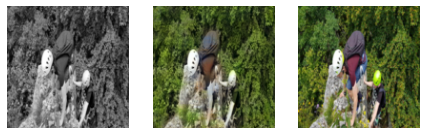

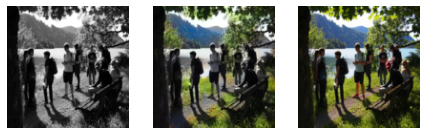

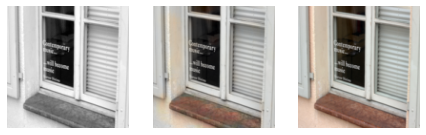

Epoch :301 0.08316174149513245
Epoch :302 0.08523400127887726
Epoch :303 0.08716209977865219
Epoch :304 0.08390824496746063
Epoch :305 0.08604977279901505
Epoch :306 0.09328356385231018
Epoch :307 0.08337537199258804
Epoch :308 0.08803538978099823
Epoch :309 0.08663500100374222
Epoch :310 0.08368679136037827
Epoch :311 0.08286634832620621
Epoch :312 0.08445633947849274
Epoch :313 0.07731593400239944
Epoch :314 0.08088597655296326
Epoch :315 0.08045807480812073
Epoch :316 0.088702492415905
Epoch :317 0.08818436414003372
Epoch :318 0.0859423577785492
Epoch :319 0.09923958778381348
Epoch :320 0.08464089781045914
Epoch :321 0.08253216743469238
Epoch :322 0.08351227641105652
Epoch :323 0.08247895538806915
Epoch :324 0.08747813105583191
Epoch :325 0.08208700269460678
Epoch :326 0.08291833847761154
Epoch :327 0.08195983618497849
Epoch :328 0.08615367114543915
Epoch :329 0.09049423784017563
Epoch :330 0.08427850157022476
Epoch :331 0.08381727337837219
Epoch :332 0.08617004007101059
Epoch :333 

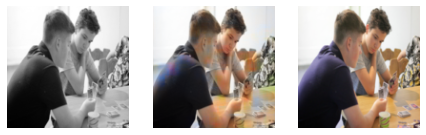

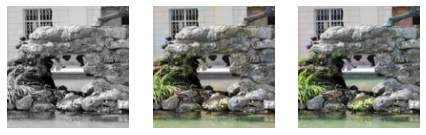

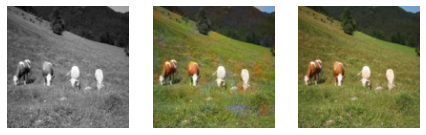

Epoch :401 0.07884229719638824
Epoch :402 0.07786577194929123
Epoch :403 0.08081496506929398
Epoch :404 0.0816141813993454
Epoch :405 0.07341381162405014
Epoch :406 0.08007188141345978
Epoch :407 0.08202638477087021
Epoch :408 0.07596877217292786
Epoch :409 0.08135966211557388
Epoch :410 0.07419811934232712
Epoch :411 0.08268748968839645
Epoch :412 0.08032608032226562
Epoch :413 0.08064951747655869
Epoch :414 0.08209843933582306
Epoch :415 0.07868926972150803
Epoch :416 0.08054620027542114
Epoch :417 0.08005084097385406
Epoch :418 0.08351162821054459
Epoch :419 0.08298492431640625
Epoch :420 0.08078747242689133
Epoch :421 0.07989277690649033
Epoch :422 0.0776800811290741
Epoch :423 0.08188246190547943
Epoch :424 0.07615779340267181
Epoch :425 0.07359448075294495
Epoch :426 0.08366630971431732
Epoch :427 0.07565274089574814
Epoch :428 0.07346393167972565
Epoch :429 0.08122227340936661
Epoch :430 0.07693185657262802
Epoch :431 0.08180870115756989
Epoch :432 0.08446110039949417
Epoch :433

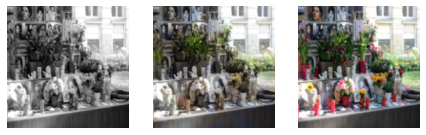

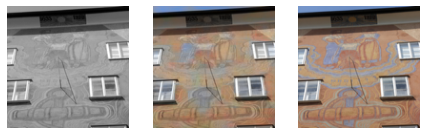

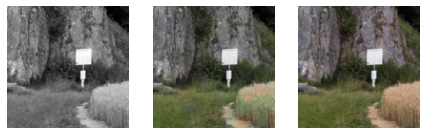

Epoch :501 0.07524412125349045
Epoch :502 0.07535897195339203
Epoch :503 0.0775090903043747
Epoch :504 0.08280934393405914
Epoch :505 0.0808609127998352
Epoch :506 0.07306870073080063
Epoch :507 0.08217176795005798
Epoch :508 0.08081822842359543
Epoch :509 0.07736534625291824
Epoch :510 0.0708766058087349
Epoch :511 0.07453296333551407
Epoch :512 0.07290881872177124
Epoch :513 0.0785527303814888
Epoch :514 0.07345259934663773
Epoch :515 0.074039526283741
Epoch :516 0.07314524054527283
Epoch :517 0.07334060966968536
Epoch :518 0.07519007474184036
Epoch :519 0.0798867717385292
Epoch :520 0.07698608189821243
Epoch :521 0.0760926827788353
Epoch :522 0.07377251237630844
Epoch :523 0.07803906500339508
Epoch :524 0.07259006798267365
Epoch :525 0.0777130201458931
Epoch :526 0.07585541903972626
Epoch :527 0.07312378287315369
Epoch :528 0.07097720354795456
Epoch :529 0.0806494951248169
Epoch :530 0.07487897574901581
Epoch :531 0.07495829463005066
Epoch :532 0.07736742496490479
Epoch :533 0.07800

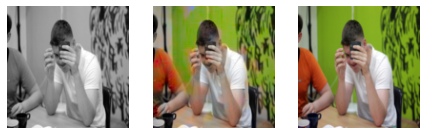

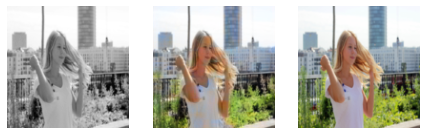

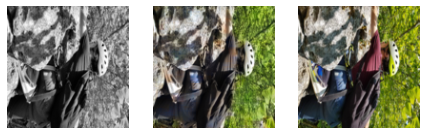

Epoch :601 0.07485882192850113
Epoch :602 0.07330296188592911
Epoch :603 0.06965940445661545
Epoch :604 0.07951504737138748
Epoch :605 0.07898157089948654
Epoch :606 0.07373764365911484
Epoch :607 0.07495567947626114
Epoch :608 0.06984806805849075
Epoch :609 0.07482317090034485
Epoch :610 0.07055595517158508
Epoch :611 0.07733409106731415
Epoch :612 0.07139786332845688
Epoch :613 0.07469765841960907
Epoch :614 0.07328645884990692
Epoch :615 0.07949122786521912
Epoch :616 0.07305040955543518
Epoch :617 0.08000335097312927
Epoch :618 0.06976403295993805
Epoch :619 0.07276757061481476
Epoch :620 0.07338680326938629
Epoch :621 0.07514188438653946
Epoch :622 0.07339557260274887
Epoch :623 0.06944504380226135
Epoch :624 0.07480215281248093
Epoch :625 0.06992678344249725
Epoch :626 0.07714840024709702
Epoch :627 0.07938817888498306
Epoch :628 0.07689684629440308
Epoch :629 0.0734647884964943
Epoch :630 0.07557801902294159
Epoch :631 0.07217834144830704
Epoch :632 0.07020575553178787
Epoch :63

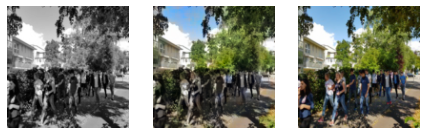

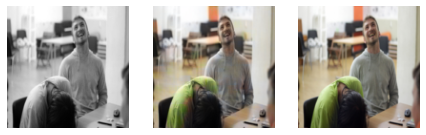

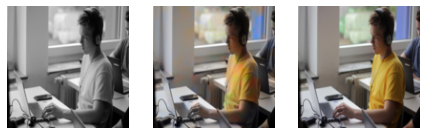

Epoch :701 0.07061859965324402
Epoch :702 0.07141510397195816
Epoch :703 0.07355936616659164
Epoch :704 0.06995587050914764
Epoch :705 0.07798798382282257
Epoch :706 0.06502977013587952
Epoch :707 0.07227484881877899
Epoch :708 0.07397253811359406
Epoch :709 0.07250918447971344
Epoch :710 0.07001978158950806
Epoch :711 0.0736318975687027
Epoch :712 0.07581912726163864
Epoch :713 0.07603885978460312
Epoch :714 0.07323817908763885
Epoch :715 0.06861943751573563
Epoch :716 0.07300565391778946
Epoch :717 0.06773491203784943
Epoch :718 0.07024934142827988
Epoch :719 0.07032553106546402
Epoch :720 0.07608158886432648
Epoch :721 0.0735902413725853
Epoch :722 0.0747840479016304
Epoch :723 0.07390151917934418
Epoch :724 0.07192477583885193
Epoch :725 0.07282746583223343
Epoch :726 0.07042352855205536
Epoch :727 0.07302665710449219
Epoch :728 0.07472856342792511
Epoch :729 0.06890098750591278
Epoch :730 0.07796886563301086
Epoch :731 0.07275361567735672
Epoch :732 0.06791047006845474
Epoch :733 

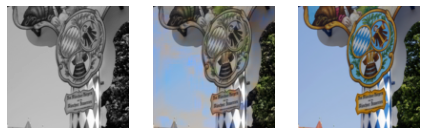

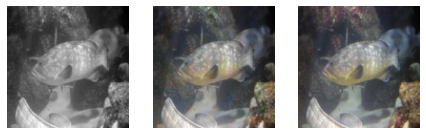

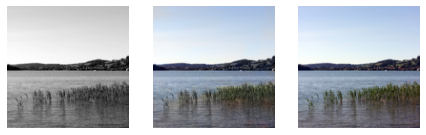

Epoch :801 0.07057850062847137
Epoch :802 0.07189778983592987
Epoch :803 0.07314662635326385
Epoch :804 0.06833934783935547
Epoch :805 0.0764290988445282
Epoch :806 0.06641478091478348
Epoch :807 0.06662023812532425
Epoch :808 0.07041310518980026
Epoch :809 0.07411153614521027
Epoch :810 0.07295762747526169
Epoch :811 0.071803018450737
Epoch :812 0.0785958543419838
Epoch :813 0.06696142256259918
Epoch :814 0.07280326634645462
Epoch :815 0.06700179725885391
Epoch :816 0.07269962877035141
Epoch :817 0.07187031954526901
Epoch :818 0.07038778066635132
Epoch :819 0.07613455504179001
Epoch :820 0.06882618367671967
Epoch :821 0.08507130295038223
Epoch :822 0.07311423867940903
Epoch :823 0.07356301695108414
Epoch :824 0.06901765614748001
Epoch :825 0.07026056945323944
Epoch :826 0.0717540755867958
Epoch :827 0.06897469609975815
Epoch :828 0.07028984278440475
Epoch :829 0.07081344723701477
Epoch :830 0.07421573996543884
Epoch :831 0.07058984041213989
Epoch :832 0.0695250853896141
Epoch :833 0.0

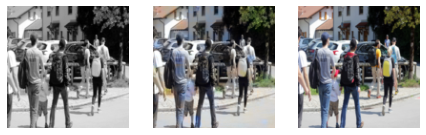

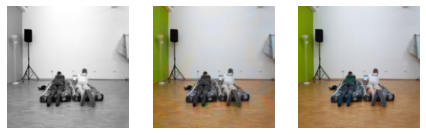

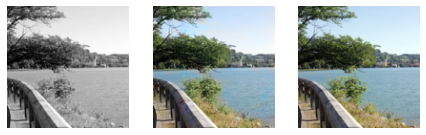

Epoch :901 0.06916379183530807
Epoch :902 0.06488657742738724
Epoch :903 0.06795109063386917
Epoch :904 0.06895431876182556
Epoch :905 0.06918467581272125
Epoch :906 0.0687684491276741
Epoch :907 0.07032261788845062
Epoch :908 0.06802316009998322
Epoch :909 0.06879754364490509
Epoch :910 0.07190722227096558
Epoch :911 0.06872168183326721
Epoch :912 0.06635046750307083
Epoch :913 0.06953608244657516
Epoch :914 0.06700798124074936
Epoch :915 0.06725803762674332
Epoch :916 0.07307128608226776
Epoch :917 0.0756116434931755
Epoch :918 0.0708962231874466
Epoch :919 0.06838005781173706
Epoch :920 0.06865250319242477
Epoch :921 0.07253962755203247
Epoch :922 0.07264858484268188
Epoch :923 0.07127273827791214
Epoch :924 0.07145680487155914
Epoch :925 0.06900591403245926
Epoch :926 0.06586318463087082
Epoch :927 0.07416070997714996
Epoch :928 0.06654925644397736
Epoch :929 0.07072915881872177
Epoch :930 0.0693027526140213
Epoch :931 0.06796221435070038
Epoch :932 0.06748156249523163
Epoch :933 0

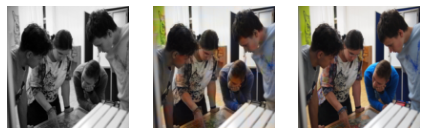

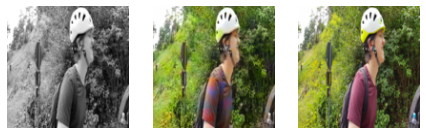

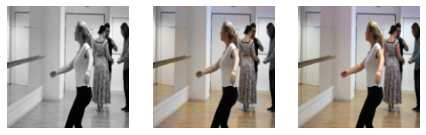

In [35]:
history = []
for epoch in range(num_epochs):
    print('Epoch :{}'.format(epoch), end=' ')
    for x, y, _, _ in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        colors = model(x)

        loss = criterion(colors, y)
        history.append(loss.item())
        loss.backward()
        optimizer.step()
        history.append(loss)
    print(loss.item())
    if epoch % 100 == 0:
      show_results(3)

In [36]:
from google.colab import files
torch.save(model.state_dict(), 'model.pth')

files.download('model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
def lab_to_rgb(L, ab, L_norm, ab_norm):
    L = (L + 1.) * L_norm
    ab = ab * ab_norm
    Lab = torch.cat([L, ab]).permute(1, 2, 0).cpu().numpy()
    return lab2rgb(Lab)

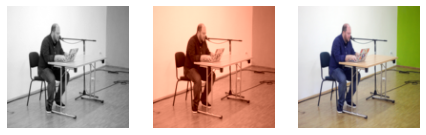

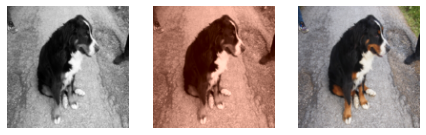

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


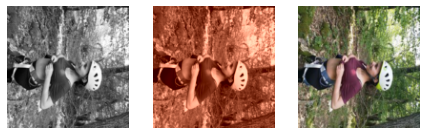

In [14]:
def show_results(num):
  for i in range(num):
      t = np.random.randint(0, len(dataset))
      L, ab, L_norm, ab_norm = dataset[t]


      img_true = lab_to_rgb(L, ab, L_norm, ab_norm)
      img_pred = model(L.to(device).view(1, 1, 128, 128))
      img_pred = lab_to_rgb(L.to(device), img_pred.view(2, 128, 128).detach(), L_norm, ab_norm)
      
      plt.figure(figsize=(10,10))
      
      plt.subplot(141)
      plt.axis('off')
      plt.imshow(L[0], cmap='gray')

      plt.subplot(142)
      plt.axis('off')
      plt.imshow(img_pred)

      plt.subplot(143)
      plt.axis('off')
      plt.imshow(img_true)
      
      plt.show()
show_results(3)